# Running Open-Source LLMs for Native Language Identification



### Loading Required Libraries

In [ ]:
import os
import pandas as pd
from pydantic import BaseModel, ValidationError, Field # used for validation of the output
from typing import Literal
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from openai import OpenAI
import tiktoken

### Loading Dataset

In [41]:
icle = "./data/ICLE/ICLE-NLI-results.csv"
vespa_dataset = './data/VESPA/VESPA-test.csv'
toefl_dataset = './data/TOEFL/TOEFL-test.csv'

In [42]:
# Load dataset
dataset = pd.read_csv(vespa_dataset) # change this to ICLE, TOEFL, or VESPA accordingly
print(f'Number of samples: {len(dataset)}')
# print(f'Column names are: {list(dataset.columns)}')
texts = dataset['text'].tolist()
labels = dataset ['language'].tolist()

Number of samples: 50


In [5]:
class NLI_prediction_TOEFL(BaseModel):
  native_lang: Literal['ARA', 'CHI', 'FRE', 'GER', 'HIN', 'ITA', 'JPN', 'KOR', 'SPA', 'TEL', 'TUR', 'ENG']

all_labels_TOEFL = ['ARA', 'CHI', 'FRE', 'GER', 'HIN', 'ITA', 'JPN', 'KOR', 'SPA', 'TEL', 'TUR']

class NLI_prediction_ICLE(BaseModel):
  native_lang: Literal['BUL', 'CHI', 'CZE', 'FRE', 'JPN', 'RUS', 'SPA', 'ENG']

all_labels_ICLE = ['BUL', 'CHI', 'CZE', 'FRE', 'JPN', 'RUS', 'SPA']

class NLI_prediction_VESPA(BaseModel):
  native_lang: Literal['DUT', 'FRE', 'NOR', 'SWE', 'SPA', 'ENG']

all_labels_VESPA = ['DUT', 'FRE', 'NOR', 'SWE', 'SPA']

all_labels_TOEFL_open = ['ARA', 'CHI', 'FRE', 'GER', 'HIN', 'ITA', 'JPN', 'KOR', 'SPA', 'TEL', 'TUR', 'ENG', 'other']
all_labels_ICLE_open = ['BUL', 'CHI', 'CZE', 'FRE', 'JPN', 'RUS', 'SPA', 'ENG', 'other']
all_labels_VESPA_open = ['DUT', 'FRE', 'NOR', 'SWE', 'SPA', 'ENG', 'other']

# Prompting LLMs

## Defining the prompts for closed-class

In [6]:
prompt_TOEFL = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "ARA": Arabic
  "CHI": Chinese
  "FRE": French
  "GER": German
  "HIN": Hindi
  "ITA": Italian
  "JPN": Japanese
  "KOR": Korean
  "SPA": Spanish
  "TEL": Telugu
  "TUR": Turkish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

  Valid output formats:
  Class: "ARA"
  Class: "CHI"
  Class: "FRE"
  Class: "GER"

  You ONLY respond in JSON files.
  The expected output from you is:"json {"native_lang": The chosen class, ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR}"
  '''

prompt_ICLE = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "BUL": Bulgarian
  "CHI": Chinese
  "CZE": Czech
  "FRE": French
  "JPN": Japanese
  "RUS": Russian
  "SPA": Spanish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

  Valid output formats:
  Class: "BUL"
  Class: "CHI"
  Class: "CZE"
  Class: "SPA"

  You ONLY respond in JSON files.
  The expected output from you has to be:"json {"native_lang": The chosen class, BUL, CHI, CZE, FRE, JPN, RUS, or SPA}"
  '''

prompt_VESPA = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "DUT": Dutch
  "FRE": French
  "NOR": Norwegian
  "SPA": Spanish
  "SWE": Swedish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.

  Valid output formats:
  Class: "DUT"
  Class: "SWE"
  Class: "NOR"
  Class: "SPA"

  You ONLY respond in JSON files.
  The expected output from you has to be:"json {"native_lang": The chosen class, DUT, FRE, NOR, SPA, or SWE}"
'''

main_task_prompt_TOEFL = '''Classify the text above as one of ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?
'''

main_task_prompt_ICLE = '''Classify the text above as one of BUL, CHI, CZE, FRE, JPN, RUS, or SPA. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?
'''

main_task_prompt_VESPA = '''Classify the text above as one of DUT, FRE, NOR, SPA, or SWE. Do not output any other class - do NOT choose "ENG" (English). What is the closest native language of the author of this English text from the given list?
'''


prompt_retry_eng = '''
  You previously mistakenly predicted this text as "ENG" (English). The class is NOT English.
  Please classify the native language of the author of the text again.
  '''

prompt_retry_TOEFL = '''
  Your classification is not in the list of possible languages.
  Please try again and choose only one of the following classes:
  ARA, CHI, FRE, GER, HIN, ITA, JPN, KOR, SPA, TEL, or TUR
  '''

prompt_retry_ICLE = '''
  Your classification is not in the list of possible languages.
  Please try again and choose only one of the following classes:
  BUL, CHI, CZE, FRE, JPN, RUS, or SPA
  '''

prompt_retry_VESPA = '''
  Your classification is not in the list of possible languages.
  Please try again and choose only one of the following classes:
  DUT, FRE, NOR, SPA, or SWE
'''

## Defining the prompts for open class

In [7]:
class NLI_prediction_open(BaseModel):
  native_lang: str

nli_prediction_dict = NLI_prediction_open.model_json_schema()
nli_prediction_json = json.dumps(nli_prediction_dict, indent=2)

prompt_open = '''
You are a forensic linguistics expert that reads texts written by non-native authors in order to identify their native language.

Analyze each text and identify the native language of the author.

Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide.

You ONLY respond in JSON files.
The expected output from you has to be:

json {"native_lang": ""}
'''

prompt_retry_open = '''
Your previous classification was not in the correct format. Please only respond in the following JSON format:
json {"native_lang": ""}
'''

## Defining functions for prompting

In [8]:
def generate_text(prompt):
  """
  Generate text for LLM based on input prompt
  :param prompt: input prompt
  :param max_length:
  :type prompt: str
  :type max_length: int
  """
    # Tokenize the prompt
  inputs = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
  outputs = model.generate(inputs,
                           max_new_tokens=10,
                           pad_token_id=tokenizer.eos_token_id,
                           #temperature=0.001
                           ) # set temperature here?
    # Decode the response
  response = tokenizer.decode(outputs[0], skip_special_tokens=True)

  return response

In [9]:
def clean_output(output, eos_token, output_only=False):
  """
  This function cleans up the output to remove the prompt, make sure it is in the correct format, and remove any empty lines.
  :param output: generated output
  :param eos_token: end-of-sequence token to split model output on
  :param output_only, default False: if True, extract only the newly generated output by model and remove the prompt. mostly used for debugging
  :type output: str
  :type eos_token: str
  """
  pure_output = output.split(eos_token)
  pure_output = pure_output[-1]
  pure_output = pure_output.strip()
  final_output = pure_output
  if output_only==False: # whether to extract only json-formatted string in the output or not
    predicted_classes=0
    language_class_dict = {'arabic': 'ARA',
                            'bulgarian': 'BUL',
                             'chinese': 'CHI',
                             'czech': 'CZE',
                             "french": "FRE",
                             "german": "GER",
                             "hindi": "HIN",
                             "italian": "ITA",
                             "japanese": "JPN",
                             "korean": 'KOR',
                             "spanish": "SPA",
                             "telugu": "TEL",
                             "turkish": "TUR",
                             "russian": "RUS",
                             "english": "ENG",
                             "itl": "ITA",
                             "deu": "GER",
                             "ita": "ITA",
                             "ger": "GER",
                             'norwegian': 'NOR', 
                             'dutch': 'DUT', 
                             'swedish': 'SWE'
                             }
    if '}' in final_output:
      x = output.split("}")
      for piece in x:
        if 'native_lang' in piece:
          x = piece.split(":")
          label = x[-1]
          label = label.strip()
          label = label.replace('"', '')
          label = label.replace('\n', '')
          final_output = '{"native_lang":"' + label + '"}'
    if 'Class:' in final_output:
      x = output.split("Class:")
      label = x[-1]
      label = label.strip()
      label = label.replace('"', '')
      label = label.replace('\n', '')
      label = label.replace('.', '')
      final_output = label
    for lang, label in language_class_dict.items():
      if lang in final_output.lower() or label in final_output:
        final_output = '{"native_lang":"' + label + '"}'

  return final_output

## Classification functions

In [30]:
encoder = "cl100k_base"
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string.
    Taken from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb"""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def truncate_text(string, encoding_name = 'cl100k_base', max_length):
    """Truncate texts from the right using the tiktoken library. 
    :param string: a given text
    :param encoding_name: encoding name, for both gpt-3.5 and gpt-4 cl100k_base
    :param max_length: num of max tokens
    :type string: str
    :type encoding_name: str
    :type max_length: int
    returns truncated text
    """
    encoding = tiktoken.get_encoding(encoding_name)
    tokenized = encoding.encode(string)
    diff = len(tokenized) - max_length 
    num_tokens = num_tokens_from_string(string, encoding_name)
    start = num_tokens-diff # get start token from part that should be removed
    del tokenized[start:num_tokens:]
    return encoding.decode(tokenized) 

In [33]:
def classify(texts, goldlabels, dataset, filter_token, closedopen_setting="closed"):
  '''
  :param texts: list of texts
  :param goldlabels: list of gold labels
  :param dataset: TOEFL/ICLE/VESPA
  :param filter_token: token to get only generated output
  :param closedopen_setting: to define closed or open setting
  :type texts: list
  :type goldlabels: list
  :type dataset: str
  :type filter_token: str
  :returns predictions: a list of model predictions
  '''
  predictions = []
  if dataset == "TOEFL": # determine which dataset it is, because the prompts and classes are different for each
    sys_prompt = prompt_TOEFL
    prompt_retry = prompt_retry_TOEFL
    all_labels = all_labels_TOEFL
    NLI_prediction = NLI_prediction_TOEFL
    main_task_prompt = main_task_prompt_TOEFL
  elif dataset == "ICLE":
    sys_prompt = prompt_ICLE
    prompt_retry = prompt_retry_ICLE
    all_labels = all_labels_ICLE
    NLI_prediction = NLI_prediction_ICLE
    main_task_prompt = main_task_prompt_ICLE
  elif dataset == 'VESPA': 
    sys_prompt = prompt_VESPA
    prompt_retry = prompt_retry_VESPA
    all_labels = all_labels_VESPA
    NLI_prediction = NLI_prediction_VESPA
    main_task_prompt = main_task_prompt_VESPA
  count = 45
  if closedopen_setting == 'open':
    main_task_prompt = ''
    sys_prompt = prompt_open
    NLI_prediction = NLI_prediction_open
    prompt_retry = prompt_retry_open
  for text, gold in zip(texts, goldlabels):
    promptcounter = 0
    num_tokens = num_tokens_from_string(text, encoder)
    if num_tokens>7900:
      text = truncate_text(text, encoder, 7900)
    main_task = text + '\n\n' + main_task_prompt
    messages = [
        {'role': "system", "content": sys_prompt},
        {'role': "user", "content": main_task}]
    # messages = [{'role': "user", "content": sys_prompt + "\n" +main_task}]
    while True:
      try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            max_tokens=13,
            seed=7)
          # print(response)
            output_only = response.choices[0].message.content
        final_output = clean_output(output_only, filter_token)
        print(output_only)
        validated_response = NLI_prediction.model_validate_json(final_output) # use class to validate json string
        response_dict = validated_response.model_dump() # dump validated response into dict
        predicted_native_lang = response_dict['native_lang'] # get the predicted native language
        if predicted_native_lang == "ENG" and closedopen_setting=="closed": # reiterate prompt if model predicts english
          messages.append({'role': 'assistant', 'content': output_only})
          messages.append({'role': "user", "content": prompt_retry_eng})
          promptcounter+=1
          if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
            response_dict = {'native_lang': 'other'}
            predictions.append('other')
            break
        else:
          predictions.append(predicted_native_lang) # append it to list of predictions
          break
      # print(final_output)
        except ValidationError as e: # if there is a validation error, make model retry
            messages.append({'role': 'assistant', 'content': output_only})
            messages.append({'role': "user", "content": prompt_retry})
        # fullprompt = "Context: " + sys_prompt + text + '\nQuestion: '+ main_task_prompt + prompt_retry + "\nAnswer:"
        # fullprompt = "Instruction: " + sys_prompt + '\n\n' + main_task_prompt + '\n' + prompt_retry + '\n\nInput: '+ text + "\nResponse:"
        promptcounter +=1
        if promptcounter > 4: # try 5 times to reprompt, if still unable to extract predicted label, append other
          response_dict = {'native_lang': 'other'}
          predictions.append('other')
          break
    print(count, response_dict)
    print('Accuracy:', "{:.2f}".format(accuracy_score(goldlabels[0:count], predictions)*100))
    count +=1
  return predictions

In [39]:
def add_results_to_csv(filepath, column_name, predictions):
  """
  Adds model predictions as the last column to existing CSV file
  with the texts and gold labels of the dataset.


  :param filepath: the path to existing CSV file
  :param column_name: name of the new column (something like preds_zero_llama7b)
  :param predictions: model predictions
  :type filepath: str
  :type column_name: str
  :type predictions: list
  """
  df = pd.read_csv(filepath)
  if column_name in df.columns:
    df = df.drop(column_name, axis=1)
  if int(len(predictions)) != int(len(df)):
    num_empty_predictions = int(len(df))-int(len(predictions))
    empty_l = [""] * num_empty_predictions
    predictions = predictions+empty_l
  num_columns = len(df.columns)
  df.insert(num_columns, column_name, predictions)
  df.to_csv(filepath, index=False)

In [10]:
import numpy as np
def evaluate(filepath, labels, pred_column, save_figure=True):
  """
  Print confusion matrix and F1 score for model predictions.
  Derives gold labels and predictions from a CSV file,
  that contains a column with gold labels that should be called 'language' and predictions from a column specified.

  :param filepath: the path to existing CSV file
  :param labels: a list of all labels/classes
  :param pred_column: the name of the column that contains the predictions
  :type filepath: str
  :type labels: list
  :type pred_column: str
  """
  df = pd.read_csv(filepath, on_bad_lines='warn')
  gold_labels = df['language'].tolist()
  predictions = df[pred_column].tolist()
  cm = confusion_matrix(gold_labels, predictions, labels=labels)
  cm_display = ConfusionMatrixDisplay(cm, display_labels=labels).plot()
  if save_figure == True:
    if 'ICLE' in filepath:
      ds='ICLE'
    elif 'TOEFL' in filepath:
      ds='TOEFL'
    elif 'VESPA' in filepath:
      ds='VESPA'
    cm_display.figure_.savefig(f'./VESPA/{pred_column}.png')
  f1score = "{:.4f}".format(f1_score(gold_labels, predictions, average="macro"))
  accuracy = accuracy_score(gold_labels, predictions)
  accuracy = "{:.2f}".format(accuracy*100)
  print(pred_column)
  print('F1: ' + str(f1score) + '\nAccuracy: ' + str(accuracy))

# OpenAI experiments

In [28]:
# Use OpenAI API to access the models. Add your own API key here.
client = OpenAI(
  api_key='ADD_YOUR_OWN_KEY'
)

In [ ]:
# perform run
eos_token = "assistant" 
model="gpt-4-0613" # define specific model
# model="gpt-3.5-turbo" for GPT-3.5
predictions = classify(texts, labels, "VESPA", eos_token, closedopen_setting='open')

results_column='preds_gpt4_open'
results_fp = './data/VESPA/VESPA-test.csv' # set filepath to results
add_results_to_csv(vespa_dataset, results_column, predictions) # append column to csv
evaluate(results_fp, all_labels_VESPA_open, results_column, save_figure=True) # evaluate

## Leverage GPT-3.5 & GPT-4 for reasoning
Here, we prompt the models to provide explanations for certain classifications and add it to the existing CSV file that contains the small sample of texts used for this experiment. 

In [5]:
sysprompt_erroranalysis_TOEFL = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "ARA": Arabic
  "CHI": Chinese
  "FRE": French
  "GER": German
  "HIN": Hindi
  "ITA": Italian
  "JPN": Japanese
  "KOR": Korean
  "SPA": Spanish
  "TEL": Telugu
  "TUR": Turkish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.'''

sysprompt_erroranalysis_ICLE = '''
  You are a forensic linguistics expert that reads English texts written by non-native authors to classify the native language of the author as one of:
  "BUL": Bulgarian
  "CHI": Chinese
  "CZE": Czech
  "FRE": French
  "JPN": Japanese
  "RUS": Russian
  "SPA": Spanish
  Use clues such as spelling errors, word choice, syntactic patterns, and grammatical errors to decide on the native language of the author.\n\n

  DO NOT USE ANY OTHER CLASS.
  IMPORTANT: Do not classify any input as "ENG" (English). English is an invalid choice.
'''

In [9]:
def add_reasonings(sample_fp):
  if 'toefl' in sample_fp:
    sys_prompt = sysprompt_erroranalysis_TOEFL
  elif 'icle' in sample_fp:
    sys_prompt = sysprompt_erroranalysis_ICLE
  sample_df = pd.read_csv(sample_fp)
  reasonings = []
  count=1
  for text, pred in zip(sample_df['text'], sample_df['prediction']):
    main_task = f'''{text}\n\nYou must provide a guess. Output two named sections: (1) "Native Language" with the name of the language, and (2) "Reasoning" with a detailed explanation of your judgement with examples from the text.'''
    messages = [
        {'role': "system", "content": sys_prompt},
        {'role': "user", "content": main_task}]
    # messages = [{'role': "user", "content": sys_prompt + "\n" +main_task }]
    # fullprompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    response = client.chat.completions.create(
              model=model,
              messages=messages,
              max_tokens=500,
              seed=7)
    output_only = response.choices[0].message.content
    print(count)
    print(output_only)
    count+=1
    reasonings.append(output_only)
  column = len(sample_df.columns)
  sample_df.insert(column, 'explanations_GPT4', reasonings)
  sample_df.to_csv(sample_fp, index=False)
  return reasonings

In [10]:
results = "./toefl_explainability_sample.csv"
eos_token_llama = 'assistant'
model="gpt-4-0613"
reasonings = add_reasonings(results)

1
Native Language: CHI

Reasoning: This author appears to be a native Chinese speaker. One clue is their incorrect use of the plural form, as in "communities" instead of "the community," which suggest that the author is from a language background that doesn't differentiate verbs based on singular or plural nouns, just like Chinese. Another clue is the overuse of "a lot of" which is the literal translation of a common phrase in Mandarin Chinese. The author also has difficulty using articles properly ("a", "an", and "the"), dropping them at times or using them in incorrect places, a common issue for Chinese speakers because Chinese doesn't have a definite or indefinite article. The author also seems to have trouble with prepositions, as evidenced by "get involve in" instead of "get involved in". This kind of preposition misuse is typical of a Chinese author.
2
Native Language: JPN

Reasoning: This author's text suggests that they are a native Japanese speaker. Several clues point to this

## Loading model tokenizer

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:757: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
}
```

The text is written by a French author. The text exhibits many characteristics of French language usage, such as the
468 {'native_lang': 'FRE'}
F1 score: 0.11
```json
{
"native_lang": "FRE"
}
```

The text is closest to French. The text exhibits many linguistic features of French, such as the use of definite
469 {'native_lang': 'FRE'}
F1 score: 0.11
```json
{
"native_lang": "FRE"
}
```

The text is written by a French author. The text exhibits many linguistic characteristics of French, such as the use
470 {'native_lang': 'FRE'}
F1 score: 0.11
```json
{
"native_lang": "FRE"
}
```

The text exhibits strong similarities to French, particularly in its syntax, word choice, and spelling errors.
471 {'native_lang': 'FRE'}
F1 score: 0.10
```json
{
"native_lang": "FRE"
}
```

The text exhibits many linguistic characteristics of French, such as the use of definite articles, the use of the verb
472 {'native_lang': 'FRE'}
F1 score: 0.10
```

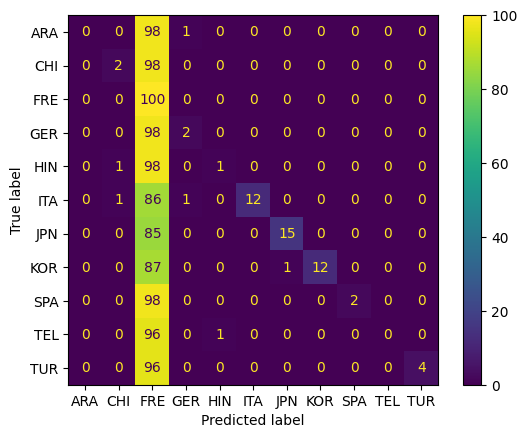

In [ ]:
# Load model with model name and bitsandbytes configuration
#model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
for count in range(2,3):
  model_name = "google/gemma-7b-it"

  bnb_config = BitsAndBytesConfig(load_in_4bit=True,
                                bnb_4bit_compute_dtype=torch.float16
                                )

  model, tokenizer = load_model(model_name, bnb_config)
  eos_token = 'model'
  # results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
  results_TOEFL = "/content/drive/MyDrive/thesis_NLI/TOEFL11/toefl_results.csv"
  results_column = f"preds_zero_gemma_7b_{count}"
  predictions_TOEFL = classify(texts, labels, "TOEFL", eos_token, results_TOEFL, results_column)
  add_results_to_csv(results_TOEFL, results_column, predictions_TOEFL)
  evaluate(results_TOEFL, all_labels_TOEFL, results_column, save_figure=True)

## Prompting for closed-set

In [ ]:
eos_token = 'model'
results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
# results_TOEFL = "/content/drive/MyDrive/thesis_NLI/TOEFL11/toefl_results.csv"
results_column = "preds_zero_gemma_7b"
predictions_ICLE = classify(texts, labels, "ICLE", eos_token, results_ICLE, results_column)
add_results_to_csv(results_ICLE, results_column, predictions_ICLE)

Streaming output truncated to the last 5000 lines.
```
76 {'native_lang': 'FRE'}
F1 score: 0.15
```json
{"native_lang": "FRE"}

The text is closest to French.
```
77 {'native_lang': 'FRE'}
F1 score: 0.14
```json
{"native_lang": "FRE"}

The text is closest to French.
```
78 {'native_lang': 'FRE'}
F1 score: 0.14
```json
{"native_lang": "BUL"}

The text is closest to Bulgarian.
```
79 {'native_lang': 'BUL'}
F1 score: 0.15
```json
{"native_lang": "BUL"}

The text is written by a Bulgarian author, therefore the closest native language to the text is Bulgarian.
```
80 {'native_lang': 'BUL'}
F1 score: 0.16
```json
{"native_lang": "FRE"}

The text is written by a French author.
```
81 {'native_lang': 'FRE'}
F1 score: 0.16
```json
{"native_lang": "FRE"}

The text is closest to French.
```
82 {'native_lang': 'FRE'}
F1 score: 0.15
```json
{"native_lang": "FRE"}

The text is closest to French.
```
83 {'native_lang': 'FRE'}
F1 score: 0.15
```json
{"native_lang": "FRE"}

The text is closest to Frenc

In [ ]:
#results_TOEFL = "/content/drive/MyDrive/thesis_NLI/TOEFL11/toefl_results.csv"
results_ICLE = "/content/drive/MyDrive/thesis_NLI/ICLE-NLI-results.csv"
results_column = "preds_zero_gemma_7b_openclass"
predictions_ICLE = classify(texts, labels, "ICLE", eos_token, results_ICLE, results_column, closedopen_setting='open')
add_results_to_csv(results_ICLE, results_column, predictions_ICLE)

Streaming output truncated to the last 5000 lines.
The text is written in English. The author's native language is English.
157 {'native_lang': 'ENG'}
F1 score: 0.05
```json
{
"native_lang": "English"
}
```

The text is written in English, therefore the native language of the author is English.
158 {'native_lang': 'ENG'}
F1 score: 0.05
```json
{"native_lang": "English"}
```

The text is written in English. The author's native language is not specified in the text, therefore I cannot identify the native language of the author.
159 {'native_lang': 'ENG'}
F1 score: 0.05
```json
{
"native_lang": "English"
}
```

The text is written in English, therefore the native language of the author is English.
160 {'native_lang': 'ENG'}
F1 score: 0.05
```json
{
"native_lang": "English"
}
```

The text is written in English, therefore the native language of the author is English.
161 {'native_lang': 'ENG'}
F1 score: 0.05
```json
{"native_lang": "English"}
```

The text is written in English, which is n